In [90]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from catboost import CatBoostRegressor
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from darts.utils.statistics import check_seasonality, plot_acf

from sklearn.linear_model import LinearRegression

from scipy.stats import t
from sklearn.model_selection import TimeSeriesSplit, train_test_split
from sklearn.metrics import mean_absolute_error
from datetime import datetime

sns.set(rc={'figure.figsize':(14.7,10)})

## Load data and EDA

In [2]:
df = pd.read_csv('ВС DS Сбер data.csv', delimiter=';')

In [3]:
df.REPORTDATE = pd.to_datetime(df.REPORTDATE, infer_datetime_format=True)

In [4]:
df.set_index('REPORTDATE', inplace=True)

In [5]:
#create hour, day and month variables from datetime index
df['week'] = df.index.isocalendar().week 
df['weekday'] = df.index.weekday
df['day'] = df.index.day
df['month'] = df.index.month

In [6]:
df.head()

,VALUE,week,weekday,day,month
REPORTDATE,,,,,
2013-12-30,3457625638,1,0,30,12
2013-12-31,3417092149,1,1,31,12
2014-01-01,3417092149,1,2,1,1
2014-01-02,3417092149,1,3,2,1
2014-01-03,3417092149,1,4,3,1


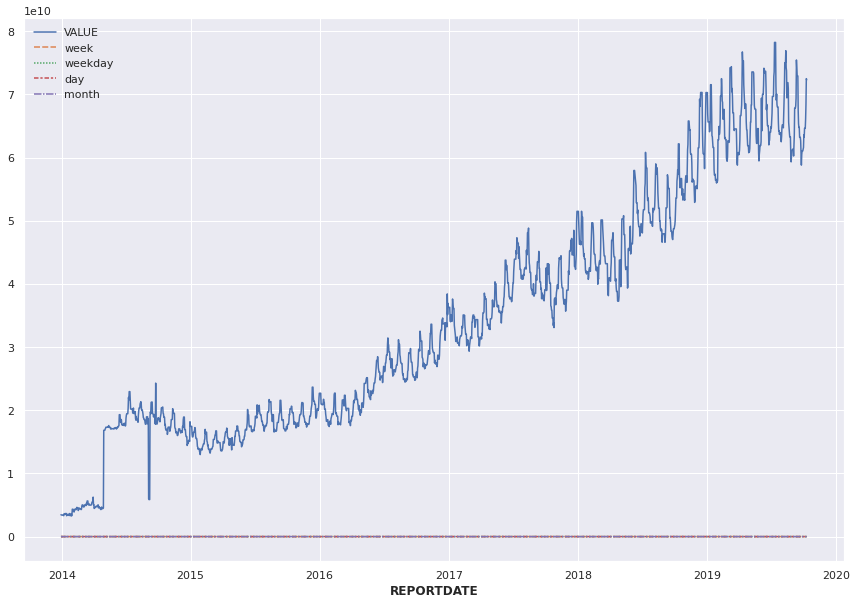

In [7]:
sns.lineplot(data=df);

In [8]:
def decompose_df(df, share_type='VALUE', samples=250, period=30):
    if samples == 'all':
        #decomposing all time series timestamps
        res = seasonal_decompose(df[share_type].values, period=period)
    else:
        #decomposing a sample of the time series
        res = seasonal_decompose(df[share_type].values[-samples:], period=period)
    
    observed = res.observed
    trend = res.trend
    seasonal = res.seasonal
    residual = res.resid
    
    #plot the complete time series
    fig, axs = plt.subplots(4, figsize=(16,8))
    axs[0].set_title('OBSERVED', fontsize=16)
    axs[0].plot(observed)
    axs[0].grid()
    
    #plot the trend of the time series
    axs[1].set_title('TREND', fontsize=16)
    axs[1].plot(trend)
    axs[1].grid()
    
    #plot the seasonality of the time series. Period=24 daily seasonality | Period=24*7 weekly seasonality.
    axs[2].set_title('SEASONALITY', fontsize=16)
    axs[2].plot(seasonal)
    axs[2].grid()
    
    #plot the noise of the time series
    axs[3].set_title('NOISE', fontsize=16)
    axs[3].plot(residual)
    axs[3].scatter(y=residual, x=range(len(residual)), alpha=0.5)
    axs[3].grid()
    
    plt.show()


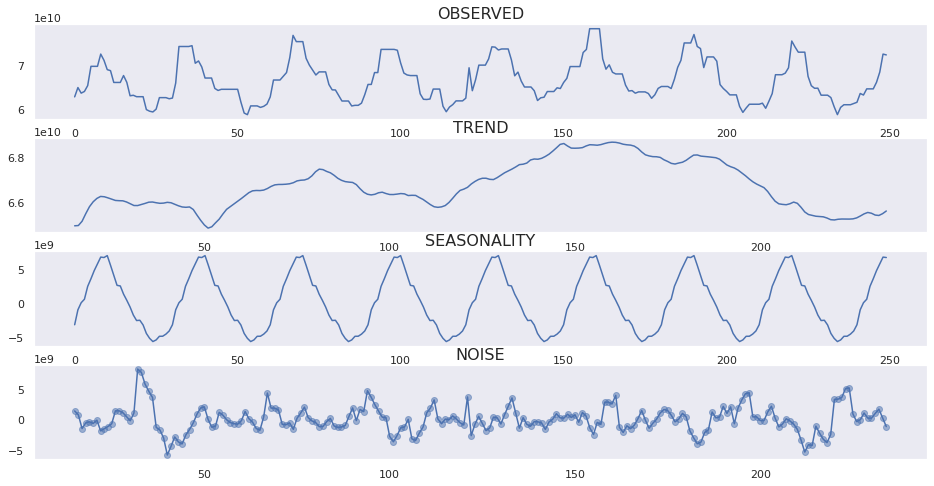

In [9]:
decompose_df(df)

In [10]:
from darts.timeseries import TimeSeries

# analyze its seasonality
ts = TimeSeries.from_dataframe(df.filter(['VALUE']))
is_seasonal, periodicity = check_seasonality(ts, max_lag=50)
dict_seas ={
    "is seasonal?":is_seasonal, 
    "periodicity (months)":f'{periodicity:.1f}', 
    "periodicity (~years)": f'{periodicity/12:.1f}'}
_ = [print(k,":",v) for k,v in dict_seas.items()]

is seasonal? : True
periodicity (months) : 28.0
periodicity (~years) : 2.3


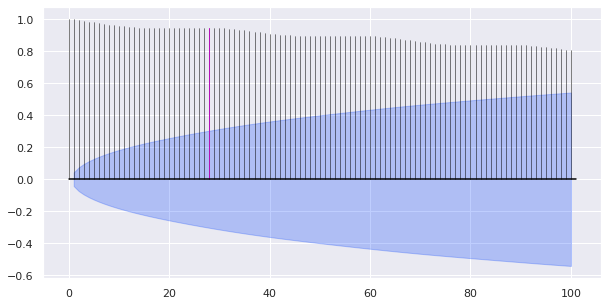

In [11]:
plot_acf(ts, periodicity, max_lag=100)

## Feature engineering

**Time lags features**

In [54]:
def generate_time_lags(df, n_lags):
    df_n = df.copy()
    for n in range(1, n_lags + 1):
        df_n[f"lag{n}"] = df_n["VALUE"].shift(n)
    df_n = df_n.iloc[n_lags:]
    return df_n

df_with_time_lags = generate_time_lags(df, 14)
df_with_time_lags.head()

,VALUE,week,weekday,day,month,lag1,lag2,lag3,lag4,lag5,lag6,lag7,lag8,lag9,lag10,lag11,lag12,lag13,lag14
REPORTDATE,,,,,,,,,,,,,,,,,,,
2014-01-13,3681610469,3,0,13,1,3.560465e+09,3.560465e+09,3.560465e+09,3.618829e+09,3.630284e+09,3.320847e+09,3.320847e+09,3.417092e+09,3.417092e+09,3.417092e+09,3.417092e+09,3.417092e+09,3.417092e+09,3.457626e+09
2014-01-14,3603764610,3,1,14,1,3.681610e+09,3.560465e+09,3.560465e+09,3.560465e+09,3.618829e+09,3.630284e+09,3.320847e+09,3.320847e+09,3.417092e+09,3.417092e+09,3.417092e+09,3.417092e+09,3.417092e+09,3.417092e+09
2014-01-15,3300717238,3,2,15,1,3.603765e+09,3.681610e+09,3.560465e+09,3.560465e+09,3.560465e+09,3.618829e+09,3.630284e+09,3.320847e+09,3.320847e+09,3.417092e+09,3.417092e+09,3.417092e+09,3.417092e+09,3.417092e+09
2014-01-16,3397894707,3,3,16,1,3.300717e+09,3.603765e+09,3.681610e+09,3.560465e+09,3.560465e+09,3.560465e+09,3.618829e+09,3.630284e+09,3.320847e+09,3.320847e+09,3.417092e+09,3.417092e+09,3.417092e+09,3.417092e+09
2014-01-17,3513671586,3,4,17,1,3.397895e+09,3.300717e+09,3.603765e+09,3.681610e+09,3.560465e+09,3.560465e+09,3.560465e+09,3.618829e+09,3.630284e+09,3.320847e+09,3.320847e+09,3.417092e+09,3.417092e+09,3.417092e+09


**Cyclical features**

In [15]:
def generate_cyclical_features(df, col_name, period, start_num=0):
    kwargs = {
        f'sin_{col_name}' : lambda x: np.sin(2*np.pi*(df[col_name]-start_num)/period),
        f'cos_{col_name}' : lambda x: np.cos(2*np.pi*(df[col_name]-start_num)/period)    
             }
    return df.assign(**kwargs).drop(columns=[col_name])

# df_cyclical_features = generate_cyclical_features(df, 'weekday', 7, 0)
# df_cyclical_features = generate_cyclical_features(df, 'month', 12, 1)
# df_cyclical_features = generate_cyclical_features(df, 'week', 52, 0)

df_cyclical_features = pd.concat([
    generate_cyclical_features(df, 'weekday', 7, 0).drop(['day', 'week', 'month'], axis=1),
    generate_cyclical_features(df, 'month', 12, 1).drop(['day', 'weekday', 'week', 'VALUE'], axis=1),
    generate_cyclical_features(df, 'week', 52, 0).drop(['day', 'month', 'weekday', 'VALUE'], axis=1)
], axis=1)

In [16]:
df_cyclical_features.head()

,VALUE,sin_weekday,cos_weekday,sin_month,cos_month,sin_week,cos_week
REPORTDATE,,,,,,,
2013-12-30,3457625638,0.000000,1.000000,-0.5,0.866025,0.120537,0.992709
2013-12-31,3417092149,0.781831,0.623490,-0.5,0.866025,0.120537,0.992709
2014-01-01,3417092149,0.974928,-0.222521,0.0,1.000000,0.120537,0.992709
2014-01-02,3417092149,0.433884,-0.900969,0.0,1.000000,0.120537,0.992709
2014-01-03,3417092149,-0.433884,-0.900969,0.0,1.000000,0.120537,0.992709


**Simple shift features**

In [50]:
df_shift = df.copy()
df_shift['week_shift'] = df_shift.VALUE.shift(7)
df_shift.dropna(inplace=True)
df_shift.head()

,VALUE,week,weekday,day,month,week_shift
REPORTDATE,,,,,,
2014-01-06,3320846785,2,0,6,1,3.457626e+09
2014-01-07,3320846785,2,1,7,1,3.417092e+09
2014-01-08,3630283744,2,2,8,1,3.417092e+09
2014-01-09,3618829426,2,3,9,1,3.417092e+09
2014-01-10,3560465236,2,4,10,1,3.417092e+09


**One hot encoded features**

In [17]:
def onehot_encode_pd(df, col_name):
    for i in col_name:
        dummies = pd.get_dummies(df[i], prefix=i)
        df = pd.concat([df, dummies], axis=1).drop(columns=[i])
    return df

df_ohe_features = onehot_encode_pd(df, ['day', 'month', 'weekday','week'])
df_ohe_features.head()

,VALUE,day_1,day_2,day_3,day_4,day_5,day_6,day_7,day_8,day_9,...,week_44,week_45,week_46,week_47,week_48,week_49,week_50,week_51,week_52,week_53
REPORTDATE,,,,,,,,,,,,,,,,,,,,,
2013-12-30,3457625638,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2013-12-31,3417092149,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2014-01-01,3417092149,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2014-01-02,3417092149,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2014-01-03,3417092149,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


**Mean time lags features**

In [67]:
def code_mean(data, cat_feature, real_feature):
    """
    Возвращает словарь, где ключами являются уникальные категории признака cat_feature, 
    а значениями - средние по real_feature
    """
    return dict(data.groupby(cat_feature)[real_feature].mean())

def mean_timelag_encoding(data, lag_start=1, lag_end=14, test_size=0.15):

    data = pd.DataFrame(data.copy())
    data = data.set_index('REPORTDATE')
#     data.columns = ["y"]

    # считаем индекс в датафрейме, после которого начинается тестовый отрезок
    test_index = int(len(data) * (1 - test_size))

    # добавляем лаги исходного ряда в качестве признаков
    for i in range(lag_start, lag_end):
        data["lag_{}".format(i)] = data.VALUE.shift(i)
    
    # data.index = data.index.to_datetime()
    data["month"] = data.index.month
    data["weekday"] = data.index.weekday
    data["is_weekend"] = data.weekday.isin([5, 6]) * 1
    data['week'] = data.index.isocalendar().week 

    # считаем средние только по тренировочной части, чтобы избежать лика
    data["weekday_average"] = list(
        map(code_mean(data[:test_index], "weekday", "VALUE").get, data.weekday)
    )
    data["month_average"] = list(
        map(code_mean(data[:test_index], "month", "VALUE").get, data.month)
    )
    data["week_average"] = list(
        map(code_mean(data[:test_index], "week", "VALUE").get, data.month)
    )

    # выкидываем закодированные средними признаки
    data.drop(["month", "weekday", 'week'], axis=1, inplace=True)

    data = data.dropna()
    data = data.reset_index(drop=True)

    # разбиваем весь датасет на тренировочную и тестовую выборку
#     X_train = data.loc[:test_index].drop(["y"], axis=1)
#     y_train = data.loc[:test_index]["y"]
#     X_test = data.loc[test_index:].drop(["y"], axis=1)
#     y_test = data.loc[test_index:]["y"]

#     return X_train, X_test, y_train, y_test
    return data

In [68]:
df_mean_timelag = df.copy()
# X_train, X_test, y_train, y_test = mean_timelag_encoding(
#     df_mean_timelag, test_size=0.3
# )

df_mean_timelag = mean_timelag_encoding(df_mean_timelag, test_size=0.3)
df_mean_timelag.head()

,VALUE,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,is_weekend,weekday_average,month_average,week_average
0,3560465236,3.560465e+09,3.560465e+09,3.618829e+09,3.630284e+09,3.320847e+09,3.320847e+09,3.417092e+09,3.417092e+09,3.417092e+09,3.417092e+09,3.417092e+09,3.417092e+09,3.457626e+09,1,2.394633e+10,2.117241e+10,2.509211e+10
1,3681610469,3.560465e+09,3.560465e+09,3.560465e+09,3.618829e+09,3.630284e+09,3.320847e+09,3.320847e+09,3.417092e+09,3.417092e+09,3.417092e+09,3.417092e+09,3.417092e+09,3.417092e+09,0,2.332959e+10,2.117241e+10,2.509211e+10
2,3603764610,3.681610e+09,3.560465e+09,3.560465e+09,3.560465e+09,3.618829e+09,3.630284e+09,3.320847e+09,3.320847e+09,3.417092e+09,3.417092e+09,3.417092e+09,3.417092e+09,3.417092e+09,0,2.361359e+10,2.117241e+10,2.509211e+10
3,3300717238,3.603765e+09,3.681610e+09,3.560465e+09,3.560465e+09,3.560465e+09,3.618829e+09,3.630284e+09,3.320847e+09,3.320847e+09,3.417092e+09,3.417092e+09,3.417092e+09,3.417092e+09,0,2.369953e+10,2.117241e+10,2.509211e+10
4,3397894707,3.300717e+09,3.603765e+09,3.681610e+09,3.560465e+09,3.560465e+09,3.560465e+09,3.618829e+09,3.630284e+09,3.320847e+09,3.320847e+09,3.417092e+09,3.417092e+09,3.417092e+09,0,2.377720e+10,2.117241e+10,2.509211e+10


## Training models

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [168]:
def plot_preds(metric, predictions, y_test, title):
    metric = "{:e}".format(metric)
    title = title + ' ' + 'RMSE: ' + metric
    fig = plt.figure(figsize=(16,8))
    plt.title(title, fontsize=20)
    sns.lineplot(data=y_test, color='red')
    sns.lineplot(data=pd.Series(predictions, index=y_test.index), color='green')
    plt.legend(labels=['Real', 'Prediction'], fontsize=16)
    plt.grid()
    plt.show()
    
def make_train_data(df):
    X = np.array(df.iloc[:, 1:])
    y = df.VALUE
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.85)
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.90)
    return X_train, X_test, X_valid, y_train, y_test, y_valid

def train_catboost(model, df, grid=None):
    X_train, X_test, X_valid, y_train, y_test, y_valid = make_train_data(df)
    
    if grid is not None:
        grid_results = model.grid_search(grid, X=X_train, y=y_train, plot=True, verbose=False, refit=True)
        
    else:
        model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)],  plot=True, verbose=False, use_best_model=True)
        
    predictions = model.predict(X_test)
    rmse = np.round(mean_squared_error(y_test, predictions) ** 0.5, 3)
    plot_preds(rmse, predictions, y_test, 'Catboost')
    
def train_linear(model, df):
    X_train, X_test, X_valid, y_train, y_test, y_valid = make_train_data(df)
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    rmse = np.round(mean_squared_error(y_test, predictions) ** 0.5, 3)
    plot_preds(rmse, predictions, y_test, 'Linear model')

**Training on timelags data**

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

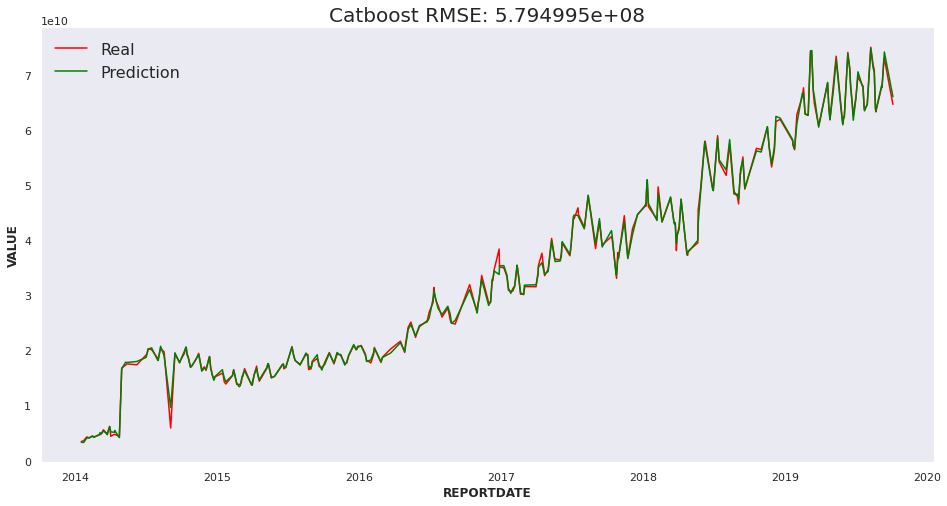

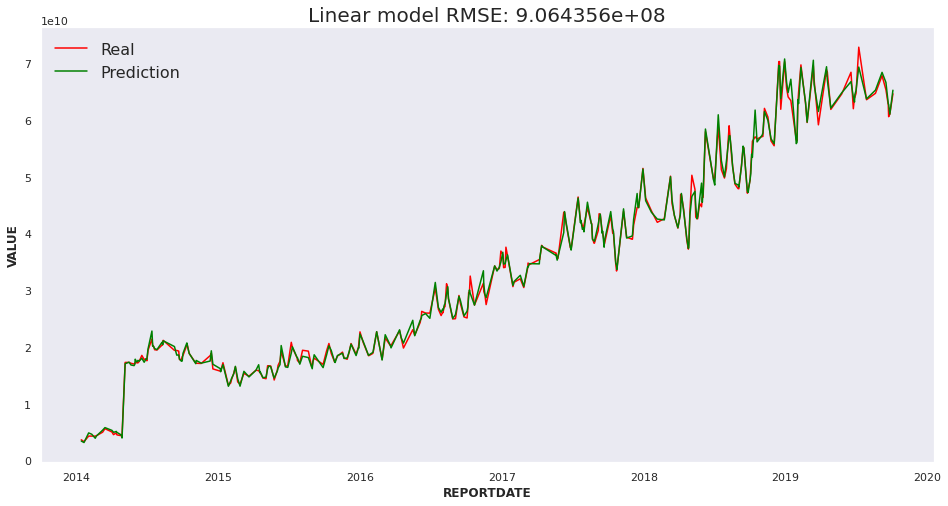

In [170]:
train_catboost(CatBoostRegressor(loss_function='RMSE', logging_level='Silent'), df_with_time_lags)
train_linear(LinearRegression(), df_with_time_lags)

**Training on cyclical data**

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

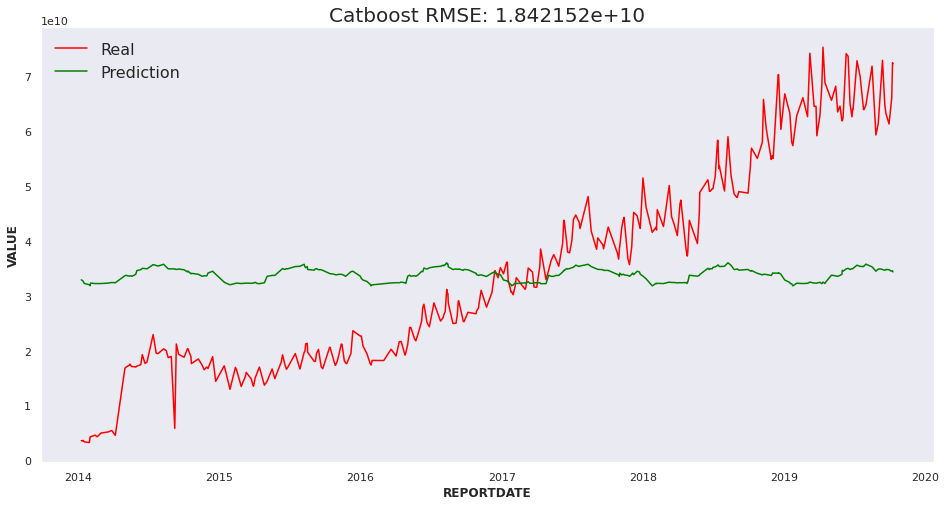

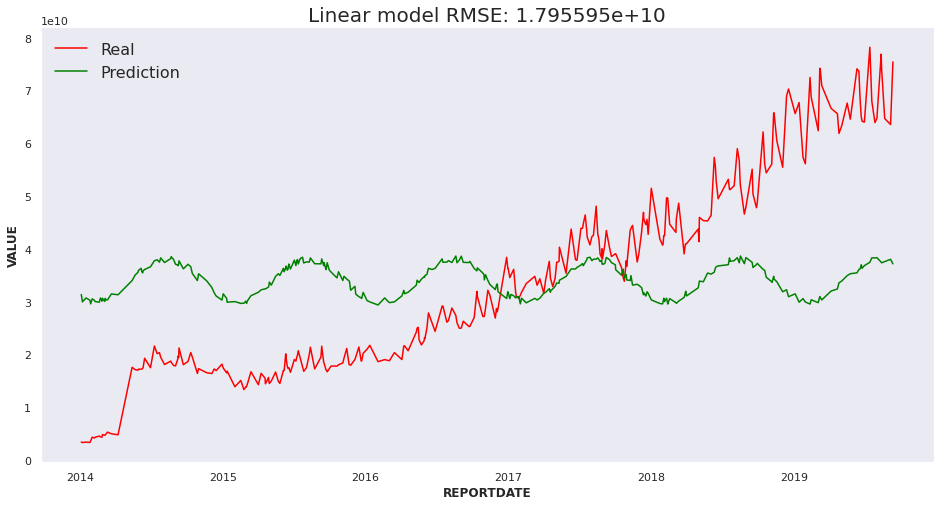

In [39]:
train_catboost(CatBoostRegressor(loss_function='RMSE', logging_level='Silent'), df_cyclical_features)
train_linear(LinearRegression(), df_cyclical_features)

**Training on simple shift data**

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

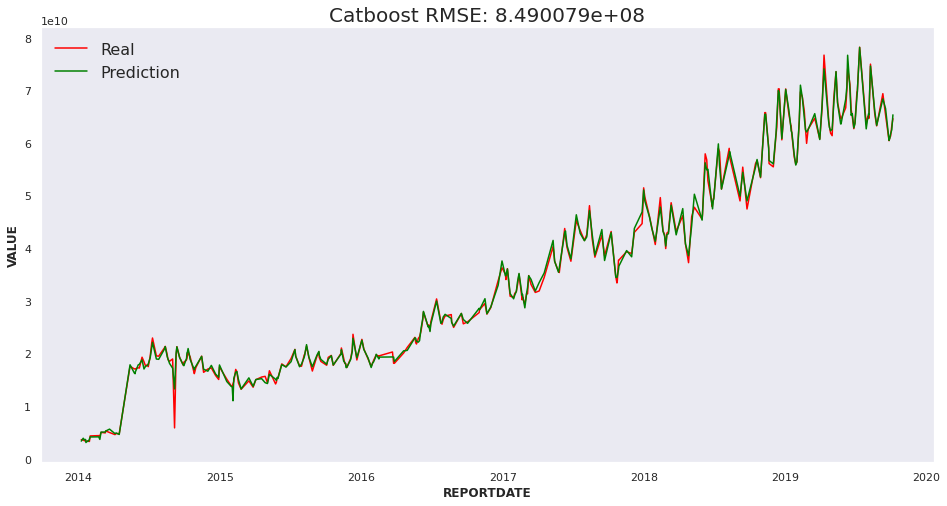

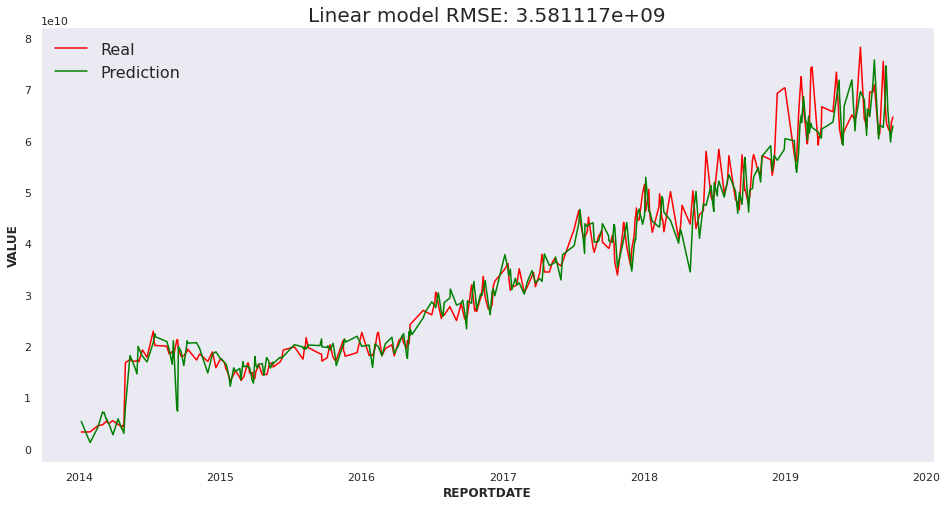

In [51]:
train_catboost(CatBoostRegressor(loss_function='RMSE', logging_level='Silent'), df_shift)
train_linear(LinearRegression(), df_shift)

**Training on mean timelags**

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

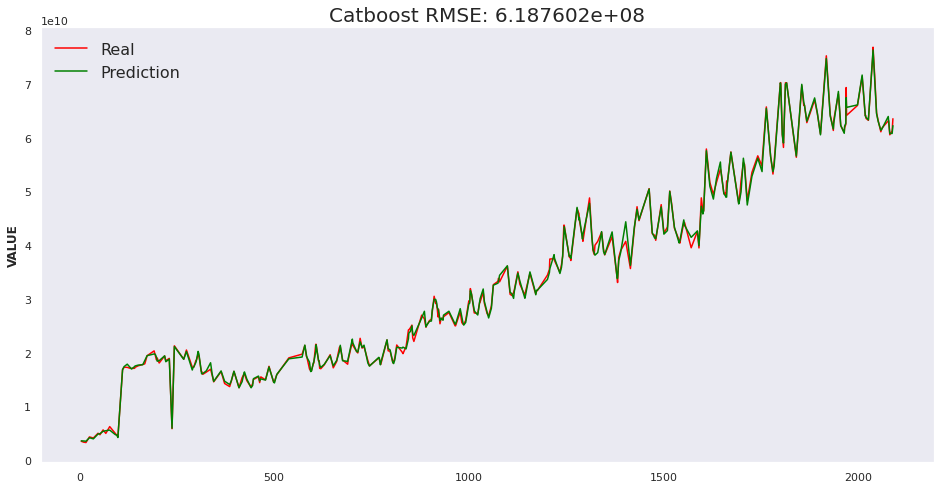

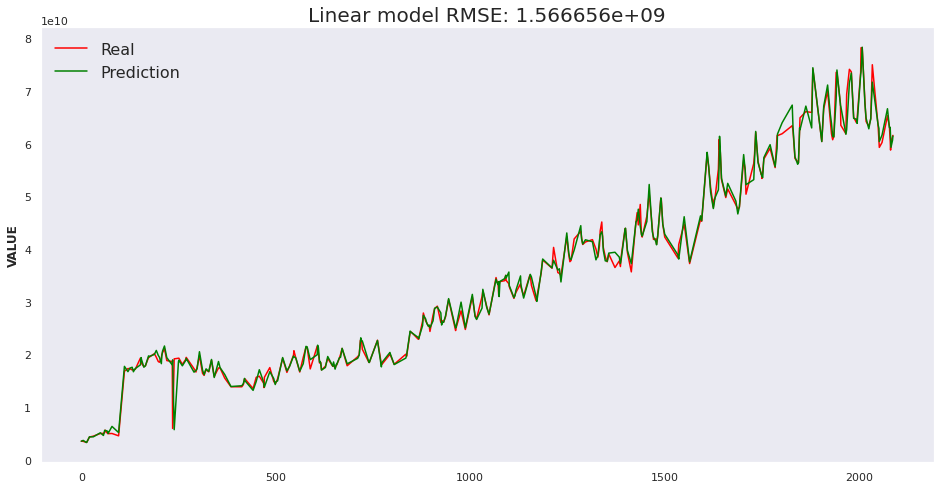

In [69]:
train_catboost(CatBoostRegressor(loss_function='RMSE', logging_level='Silent'), df_mean_timelag)
train_linear(LinearRegression(), df_mean_timelag)

**Improving best model with grid search**

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

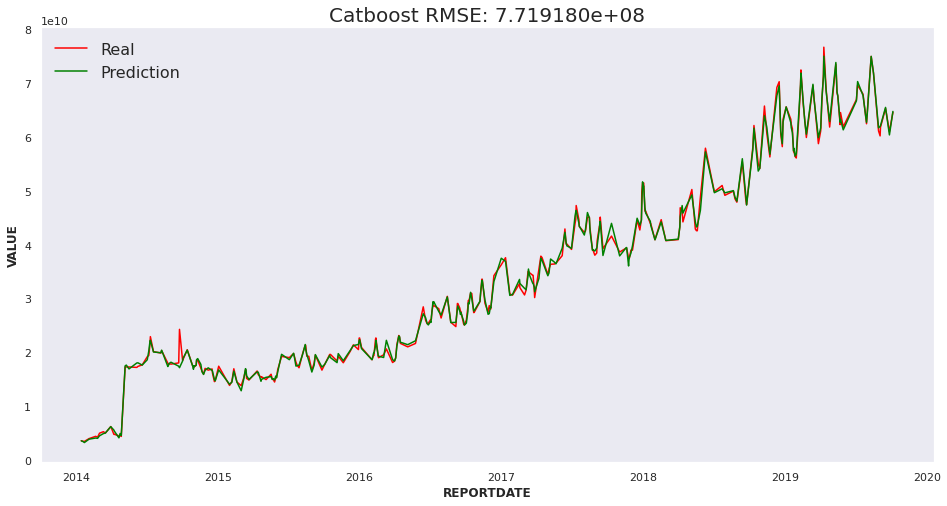

In [169]:
grid = {
        'depth': [4, 6, 10],
        'learning_rate' : [0.01, 0.05, 0.1],
        'iterations': [100, 150, 200, 1000],
        'l2_leaf_reg': [1, 3, 5, 7, 9]
}

train_catboost(CatBoostRegressor(loss_function='RMSE', logging_level='Silent'), df_with_time_lags, grid=grid)

## Training RNN

In [13]:
import torch
import torch.optim as optim
import torch.nn as nn
from tqdm.notebook import tqdm
torch.manual_seed(42)

In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [100]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, MaxAbsScaler, RobustScaler

def get_scaler(scaler):
    scalers = {
        "minmax": MinMaxScaler,
        "standard": StandardScaler,
        "maxabs": MaxAbsScaler,
        "robust": RobustScaler,
    }
    return scalers.get(scaler.lower())()
    
scaler = get_scaler('robust')

In [101]:
X_train, X_test, X_valid, y_train, y_test, y_valid = make_train_data(df_with_time_lags)

In [102]:
X_train_arr = scaler.fit_transform(X_train)
X_test_arr = scaler.transform(X_test)
X_valid_arr = scaler.transform(X_valid)

In [103]:
y_train_arr = scaler.fit_transform(np.array(y_train).reshape(-1, 1))
y_test_arr = scaler.transform(np.array(y_test).reshape(-1, 1))
y_valid_arr = scaler.transform(np.array(y_valid).reshape(-1, 1))

In [104]:
from torch.utils.data import TensorDataset, DataLoader

batch_size = 64

train_features = torch.Tensor(X_train_arr)
train_targets = torch.Tensor(y_train_arr)
val_features = torch.Tensor(X_valid_arr)
val_targets = torch.Tensor(y_valid_arr)
test_features = torch.Tensor(X_test_arr)
test_targets = torch.Tensor(y_test_arr)

train = TensorDataset(train_features, train_targets)
val = TensorDataset(val_features, val_targets)
test = TensorDataset(test_features, test_targets)

train_loader = DataLoader(train, batch_size=batch_size, shuffle=False, drop_last=True)
val_loader = DataLoader(val, batch_size=batch_size, shuffle=False, drop_last=True)
test_loader = DataLoader(test, batch_size=batch_size, shuffle=False, drop_last=True)
test_loader_one = DataLoader(test, batch_size=1, shuffle=False, drop_last=True)

In [157]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, dropout_prob):
        super(LSTMModel, self).__init__()

        # Defining the number of layers and the nodes in each layer
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim

        # LSTM layers
        self.lstm = nn.LSTM(
            input_dim, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob
        )

        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Initializing hidden state for first input with zeros
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()

        # Initializing cell state for first input with zeros
        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()

        # We need to detach as we are doing truncated backpropagation through time (BPTT)
        # If we don't, we'll backprop all the way to the start even after going through another batch
        # Forward propagation by passing in the input, hidden state, and cell state into the model
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))

        # Reshaping the outputs in the shape of (batch_size, seq_length, hidden_size)
        # so that it can fit into the fully connected layer
        out = out[:, -1, :]

        # Convert the final state to our desired output shape (batch_size, output_dim)
        out = self.fc(out)

        return out

In [158]:
input_dim = X_train.shape[1]
output_dim = 1
hidden_dim = 64
layer_dim = 3
batch_size = 64
dropout = 0.2
n_epochs = 100
learning_rate = 1e-3
weight_decay = 1e-6

In [159]:
model = LSTMModel(input_dim, hidden_dim, layer_dim, output_dim, dropout)
criterion = nn.MSELoss(reduction="mean")
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

In [160]:
class Optimization:
    def __init__(self, model, loss_fn, optimizer):
        self.model = model
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.train_losses = []
        self.val_losses = []
        self.max_loss = np.inf
        self.weights_path = f'models/model_{datetime.now().strftime("%Y-%m-%d")}'
        
    def train_step(self, x, y):
        self.model.train()
        yhat = self.model(x)
        loss = self.loss_fn(y, yhat)
        loss.backward()
        self.optimizer.step()
        self.optimizer.zero_grad()
        return loss.item()
    
    def train(self, train_loader, val_loader, batch_size=64, n_epochs=50, n_features=1):
        for epoch in tqdm(range(1, n_epochs + 1)):
            batch_losses = []
            for x_batch, y_batch in train_loader:
                x_batch = x_batch.view([batch_size, -1, n_features]).to(device)
                y_batch = y_batch.to(device)
                loss = self.train_step(x_batch, y_batch)
                batch_losses.append(loss)
            training_loss = np.mean(batch_losses)
            self.train_losses.append(training_loss)

            with torch.no_grad():
                batch_val_losses = []
                for x_val, y_val in val_loader:
                    x_val = x_val.view([batch_size, -1, n_features]).to(device)
                    y_val = y_val.to(device)
                    self.model.eval()
                    yhat = self.model(x_val)
                    val_loss = self.loss_fn(y_val, yhat).item()
                    batch_val_losses.append(val_loss)
                validation_loss = np.mean(batch_val_losses)
                self.val_losses.append(validation_loss)

            if validation_loss < self.max_loss:
                self.max_loss = validation_loss
                torch.save(self.model.state_dict(), self.weights_path)
                
            if epoch % 10 == 0:
                print(
                    f"[{epoch}/{n_epochs}] Training loss: {training_loss:.4f}\t Validation loss: {validation_loss:.4f}"
                )
        self.model.load_state_dict(torch.load(self.weights_path))

    def evaluate(self, test_loader, batch_size=1, n_features=1):
        self.model.eval()
        with torch.no_grad():
            predictions = []
            values = []
            for x_test, y_test in test_loader:
                x_test = x_test.view([batch_size, -1, n_features]).to(device)
                y_test = y_test.to(device)
                self.model.eval()
                yhat = self.model(x_test)
                predictions.append(yhat.to(device).detach().numpy())
                values.append(y_test.to(device).detach().numpy())

        return predictions, values

    def plot_losses(self):
        plt.plot(self.train_losses, label="Training loss")
        plt.plot(self.val_losses, label="Validation loss")
        plt.legend()
        plt.title("Losses")
        plt.show()
        plt.close()

In [161]:
opt = Optimization(model=model, loss_fn=criterion, optimizer=optimizer)

In [162]:
opt.train(train_loader, val_loader, batch_size=batch_size, n_epochs=n_epochs, n_features=input_dim)

  0%|          | 0/100 [00:00<?, ?it/s]

[10/100] Training loss: 0.0084	 Validation loss: 0.0047
[20/100] Training loss: 0.0062	 Validation loss: 0.0031
[30/100] Training loss: 0.0051	 Validation loss: 0.0029
[40/100] Training loss: 0.0044	 Validation loss: 0.0025
[50/100] Training loss: 0.0040	 Validation loss: 0.0027
[60/100] Training loss: 0.0044	 Validation loss: 0.0029
[70/100] Training loss: 0.0045	 Validation loss: 0.0026
[80/100] Training loss: 0.0037	 Validation loss: 0.0024
[90/100] Training loss: 0.0038	 Validation loss: 0.0024
[100/100] Training loss: 0.0037	 Validation loss: 0.0025


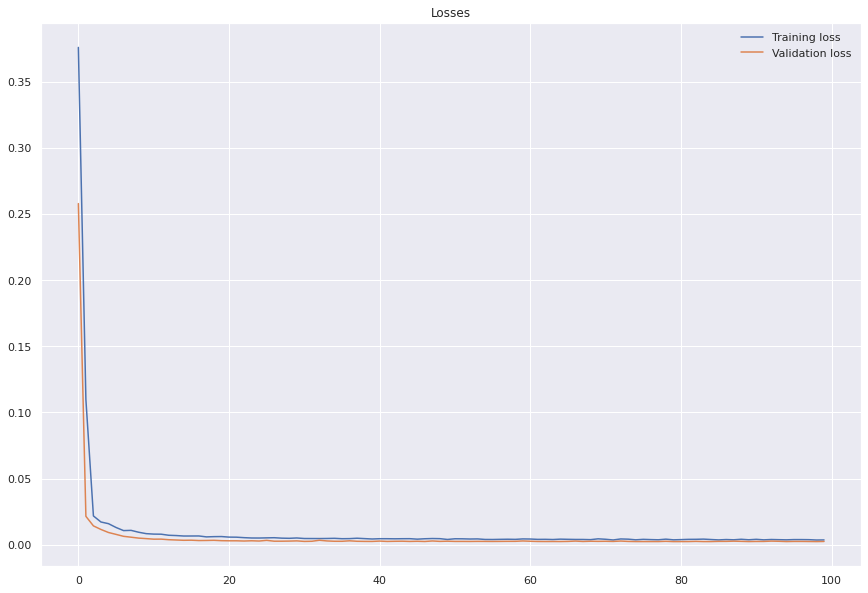

In [163]:
opt.plot_losses()

In [164]:
predictions, _ = opt.evaluate(test_loader_one, batch_size=1, n_features=input_dim)

In [165]:
def format_predictions(predictions, y_test, scaler):
    index = y_test.index
    preds = np.concatenate(predictions, axis=0).ravel()
    preds = scaler.inverse_transform(preds.reshape(-1, 1)).ravel()
    df_result = pd.DataFrame(data={"y_true": y_test, "prediction": preds}, index=index)
    return df_result

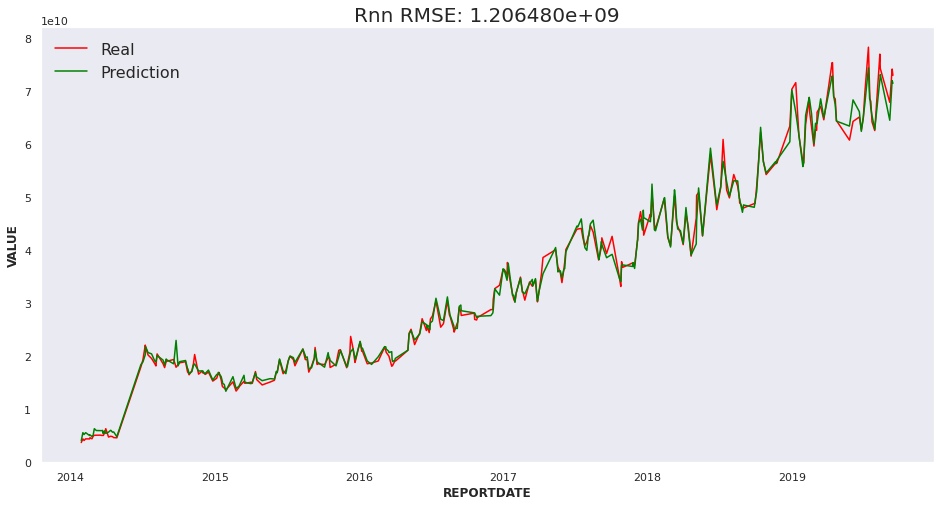

In [166]:
df_result = format_predictions(predictions, y_test, scaler)
rmse = round(mean_squared_error(df_result.y_true, df_result.prediction) ** 0.5, 2)
plot_preds(rmse, df_result.prediction, y_test, 'Rnn')